In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, HalfwayBounceBackBoundary, FullwayBounceBackBoundary, EquilibriumOutletP, AntiBounceBackOutlet
from lettuce.flows.obstaclemax import ObstacleMax

import torch
import time
import datetime
import os
import shutil

In [2]:
### Simulationsparameter - Steuerung 
re = 40   # Reynoldszahl
Ma = 0.05     # Machzahl
n_steps = 220000    # Schrittzahl
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

periodic_start = 0.9  # relative start of peak_finding for Cd_mean Measurement to cut of any transients

gridpoints_per_diameter = 20  # gp_per_D -> this defines the resolution ( D_LU = GPD+1)
domain_width_in_D = 10  # D/Y  -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2*domain_width_in_D  # D/X

# if DpY is even, resulting GPD can't be odd for symmetrical cylinder and channel
# ...if DpY is even, GPD will be corrected to even GPD for symemtrical cylinder
# ...use odd DpY to use odd GPD
gpd_correction=False
if domain_width_in_D % 2 == 0 and gridpoints_per_diameter % 2 != 0:
    gpd_correction = True   # gpd_was_corrected-flag
    gpd_setup = gridpoints_per_diameter   # store old gpd for output
    gridpoints_per_diameter = int(gridpoints_per_diameter/2)*2   # make gpd even
    print("(!) domain_width_in_D is even, gridpoints_per_diameter will be "+str(gridpoints_per_diameter)+". Use odd domain_width_in_D to enable use of odd GPD!")

T_target=300
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/(gridpoints_per_diameter+1))*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round(((gridpoints_per_diameter+1)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round(((gridpoints_per_diameter+1)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")

u_init = 0    # initiales Geschwindigkeitsfeld: # 0: uniform u=0, # 1: uniform u=1, # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # leichte Asymmetrie in Anfangs-Geschwindigkeitsverteilung -> triggert Karman'sche Wirbelstraße für Re>47
bb_wall = False    # Randbedingungen der lateralen Kanalwände: True= bounce-back-walls und parabelförmiges Geschwindigkeisprodil am Einlass, False= periodic BC und uniforme Geschwindigkeit am Einlass
cylinder = True    # Objekt: True = cylinder, False = no obstascle
halfway = True    # BounceBackBoundary-Algorithmus: True=Halfway, False=Fullway
drag_out = True    # drag_coefficient als observable-reporter
lift_out = True    # lift_coefficient als observable-reporter
vtk_fps=10    # FramesPerSecond (/PU) für vtk-output
vtk_out=True   # is overwritten by output_save=False (see below)

#exmpl: Re1000,steps25000,ny1000 braucht 43min
#Bonn: Re200, steps200000,gpd20?, 400x200 braucht 10min
#HBRS: Re200, steps100000, gpd20, 800x400 braucht 25min
#Bonn: Re200, steps175000, gpd35, 1330x665 braucht 62,3min

mlups_2060super = 20
mlups_2080ti = 30   # 40 for GPD30,DpY19,nsteps=150000 (steigend mit der Auflösung)

if vtk_out:
    print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/(gridpoints_per_diameter+1))*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**2*domain_length_in_D*domain_width_in_D
print("No. of gridpoints:", gridpoints)
print("estimated min. runtime on 2060super:", round(n_steps*gridpoints/(1e6*mlups_2060super),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2060super)/60,2),"minutes )")
print("estimated min. runtime on 2080ti:   ", round(n_steps*gridpoints/(1e6*mlups_2080ti),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2080ti)/60,2),"minutes )")

shape_LU: 400 x 200
T with 220000 steps: 302.42 seconds
n_steps to simulate 1 second: 727.46 steps
n_steps to simulate 300 seconds: 218238.0 steps
generates approx. 3025 .vti/.vtk-frames
No. of gridpoints: 80000
estimated min. runtime on 2060super: 880.0 seconds ( 14.67 minutes )
estimated min. runtime on 2080ti:    586.67 seconds ( 9.78 minutes )


In [3]:
### Data_Output (vtk)
output_save = True

# naming:
batch = "_MP1visBGK"
version = "_GPD" + str(gridpoints_per_diameter) + "_DpY" + str(domain_width_in_D) + "_Re"+str(re)

if output_save:  # toggle output
    # (see above) vtk_out = True    # vtk-Repoter für Animation des Flusses in ParaView: True = vtk-output, False = no vtk-output

    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
    #output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
    #output_path = "/home/mbille3s/02_lbm_simulations"  # cluster HBRS
    dir_name = "/data_" + str(timestamp) + batch + version
    os.makedirs(output_path+dir_name)
    
    vtk_path = output_path+dir_name+"/vtk/out"    # lokal HBRS UND Bonn # Pfad und Name der vtk-output-Dateien
    print("dir_name: "+dir_name)
    print("output_path: " + vtk_path)
else:
    vtk_out = False

dir_name: /data_230510_155729_MP1visBGK_GPD20_DpY10_Re40
output_path: /mnt/ScratchHDD1/Max_Scratch/lbm_simulations/data_230510_155729_MP1visBGK_GPD20_DpY10_Re40/vtk/out


In [4]:
### Simulationssetup

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
    # stencil, device, dtype

flow = ObstacleMax(reynolds_number=re, mach_number=Ma, 
                   lattice=lattice, 
                   char_length_pu=setup_diameter, 
                   char_length_lu=gridpoints_per_diameter+1, 
                   char_velocity_pu=flow_velocity, 
                   y_lu=domain_width_in_D*gridpoints_per_diameter, 
                   x_lu=domain_length_in_D*gridpoints_per_diameter, 
                   lateral_walls=bb_wall, 
                   hwbb=halfway, 
                   perturb_init=perturb_init, 
                   u_init=u_init
                  )

# define a Cylinder-Obstacle
radius_LU = 0.5 * gridpoints_per_diameter
y_pos_LU = 0.5 * gridpoints_per_diameter * domain_width_in_D + 0.5
x_pos_LU = y_pos_LU

xyz = tuple(np.linspace(1,n,n) for n in flow.shape)  # Tupel aus Listen inizes (1-n (nicht 0-based!))
xLU, yLU = np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Indizes

condition = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU
flow.obstacle_mask[np.where(condition)] = 1
    
    
### Simulations-Objekt (Simulator)
tau = flow.units.relaxation_parameter_lu
sim = lt.Simulation(flow, lattice, 
                     lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau), 
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, KollisionsOperator-Objekt(Parameter), Streaming-Objekt

### Reporter

# VTK Reporter -> Visualisierung
if vtk_out == True:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)

# Observable reporter: drag coefficient
if drag_out == True:
    DragObservable = lt.DragCoefficient(lattice,flow,sim,area=setup_diameter)  # erstelle Observable // ! area A=2*r is in PU
    Dragreport = lt.ObservableReporter(DragObservable, out=None)  # erstelle Reporter für Observable
    sim.reporters.append(Dragreport)  # hänge Reporter in Simulator ein
    
# Observable reporter: lift coefficient
if lift_out == True:
    LiftObservable = lt.LiftCoefficient(lattice,flow,sim,area=setup_diameter)
    Liftreport = lt.ObservableReporter(LiftObservable, out=None)
    sim.reporters.append(Liftreport)
    
# MassObservable = lt.Mass(lattice,flow)
# MassReporter = lt.ObservableReporter(MassObservable, out=None)
# sim.reporters.append(MassReporter)

In [5]:
### Einfache Simulation

t_start=time.time()

mlups = sim.step(n_steps) #Simulation mit Schrittzahl n_steps

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")
print("\Re:",re)
print("char_velocity_LU", flow.units.characteristic_velocity_lu)

MLUPS: 21.58547951891736
PU-Time:  302.4215695755183  seconds
number of steps: 220000
runtime:  815.3631029129028 seconds ( 13.59 minutes )
\Re: 40
char_velocity_LU 0.028867513459481294


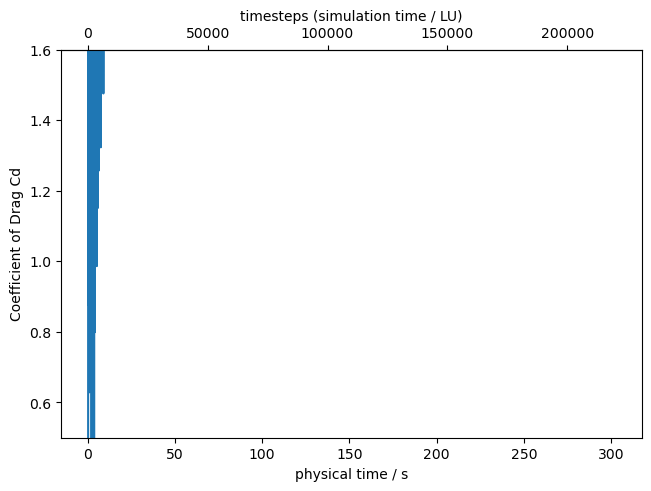

In [6]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])
#ax.set_ylim([1.54,1.545])
#ax.set_xlim([500,600])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_save:
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")
plt.show()

simple mean:      1.7640686462919883
peak_finder mean: 1.7640686462919388
start time of 'mean'-ing: 272.1780379744684


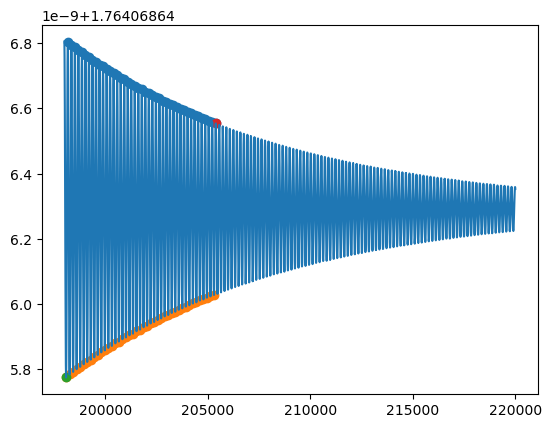

In [7]:
### calculate mean drag_coefficient in periodic reagion:
try:
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]

    peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
    peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))
    # find peaks funktioniert hier nicht korrekt, wenn der Drag immernoch ansteigend ist...

    if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
        peak_number = peaks_max[0].shape[0]
    else:
        peak_number = peaks_min[0].shape[0]

    if peaks_min[0][0] < peaks_max[0][0]:
        first_peak = peaks_min[0][0]
        last_peak = peaks_max[0][peak_number-1]
    else:
        first_peak = peaks_max[0][0]
        last_peak = peaks_min[0][peak_number-1]

    drag_mean = values[first_peak:last_peak].mean()
    drag_mean_simple = values.mean()

    print("simple mean:     ",drag_mean_simple)
    print("peak_finder mean:",drag_mean)
    print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1])
    ## plotting peaks from peak_finder:
    drag_stepsLU = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,0]
    peak_max_y = values[peaks_max[0]]
    peak_max_x = drag_stepsLU[peaks_max[0]]
    peak_min_y = values[peaks_min[0]]
    peak_min_x = drag_stepsLU[peaks_min[0]]

    plt.plot(drag_stepsLU, values)
    plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number])
    plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number])
    plt.scatter(drag_stepsLU[first_peak],values[first_peak])
    plt.scatter(drag_stepsLU[last_peak],values[last_peak])
    plt.savefig(output_path+dir_name+"/drag_coefficient_peakfinder.png")
    peakfinder=True
except:
    print("peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)")
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]
    drag_mean_simple = values.mean()
    peakfinder=False
    print("Cd, simple mean:",drag_mean_simple)

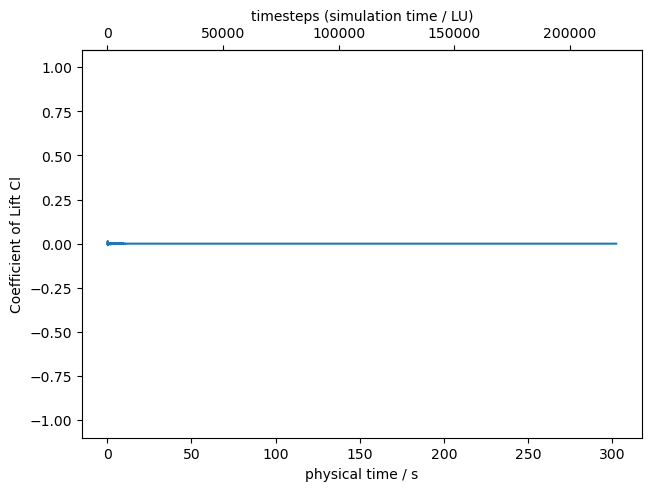

Cl_peaks: 
min -1.1294293367740124e-08 
max 1.3123299038188251e-08


In [8]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1.1,1.1])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_save:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

Cl_min = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].min()
Cl_max = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].max()
#Cl_min_gpdC = Cl_min/(1+1/gridpoints_per_diameter)
#Cl_max_gpdC = Cl_max/(1+1/gridpoints_per_diameter)

print("Cl_peaks: \nmin", Cl_min,"\nmax", Cl_max)
#print("Cl_peaks (gpd-corrected): \nmin", Cl_min_gpdC,"\nmax", Cl_max_gpdC)

Frequency Peak: 2.1294680589235044 +- 0.0033066274206886713 Hz


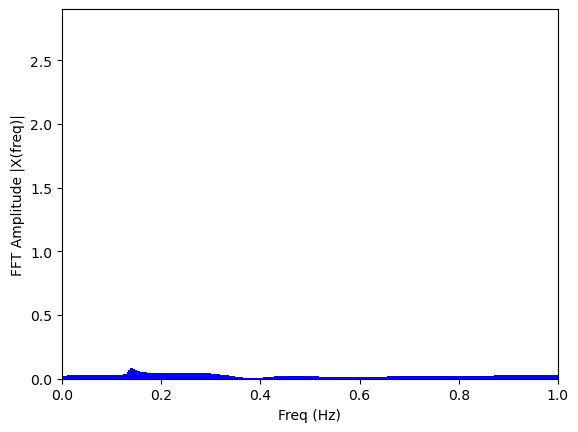

In [9]:
### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

X = np.fft.fft(lift_coefficient[:,2])   # fft result (amplitudes)
N = len(X)  # number of freqs
n = np.arange(N)   # freq index
T = N*flow.units.convert_time_to_pu(1)   # total time measured (T_PU)
freq = n/T   # frequencies (x-axis of spectrum)

plt.figure
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")   # plot spectrum |X|(f)
plt.xlabel("Freq (Hz)")
plt.ylabel("FFT Amplitude |X(freq)|")
plt.xlim(0,1)
#print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum

if output_save:
    plt.savefig(output_path+dir_name+"/fft_Cl.png")

freq_res = freq[1]-freq[0]   # frequency-resolution
X_abs = np.abs(X[:int(X.shape[0]*0.4)])   # get |X| Amplitude for left half of full spectrum
freq_peak = freq[np.argmax(X_abs)]    # find frequency with highest amplitude
print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
# f = Strouhal for St=f*D/U and D=U=1 in PU

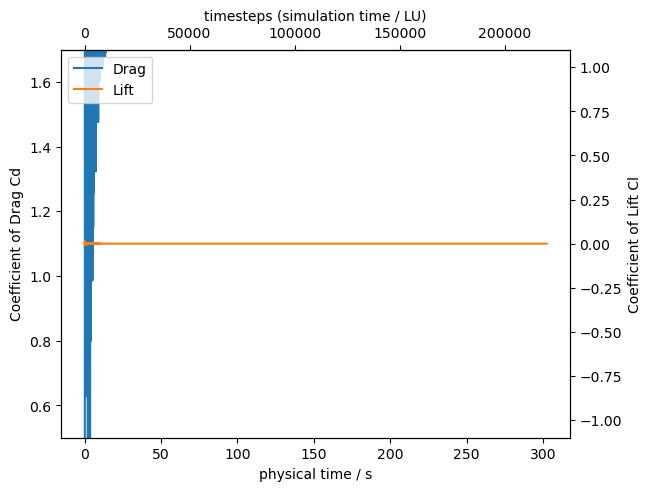

In [10]:
### plot Drag coefficient AND Lift Coefficient

#drag_coefficient = np.array(Dragreport.out)
#lift_coefficient = np.array(Liftreport.out)

fig, ax = plt.subplots(layout="constrained")
drag_ax = ax.plot(drag_coefficient[:,1],drag_coefficient[:,2], color="tab:blue", label="Drag")
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.7])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")

ax2 = ax.twinx()
lift_ax = ax2.plot(lift_coefficient[:,1],lift_coefficient[:,2], color="tab:orange", label="Lift")
ax2.set_ylabel("Coefficient of Lift Cl")
ax2.set_ylim([-1.1,1.1])


fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

if output_save:
    plt.savefig(output_path+dir_name+"/dragAndLift_coefficient.png")

plt.show()

In [11]:
### plotte Dichte (mean, max, min) im Fluid-Bereich

# plt.figure
# plt.plot(np.arange(len(DragObservable.rho_max_list)),DragObservable.rho_max_list)
# plt.plot(np.arange(len(DragObservable.rho_min_list)),DragObservable.rho_min_list)
# plt.plot(np.arange(len(DragObservable.rho_mean_list)),DragObservable.rho_mean_list)
# plt.legend(labels=["rho_max", "rho_min", "rho_mean"])
# plt.ylim([0.99,1.01])
# if output_save:
#     plt.savefig(output_path+dir_name+"/density.png")

In [12]:
# save notebook to simulation_output
if output_save:
    shutil.copy(str(os.getcwd())+"/cylinder2D_development.ipynb",output_path+dir_name+"/script.ipynb")
else:
    print("output_save-toggle is FALSE")


In [13]:
# output data
if output_save:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nMa = "+str(Ma))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nsetup_diameter (D_PU) = "+str(setup_diameter))
    output_file.write("\nflow_velocity (U_PU) = "+str(flow_velocity))
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\ndomain_width_in_D (D/Y) = "+str(domain_width_in_D))
    output_file.write("\ndomain_length_in_D (D/X) = "+str(domain_length_in_D))
    output_file.write("\n")
    output_file.write("\nu_init = "+str(u_init))
    output_file.write("\nperturb_init = "+str(perturb_init))
    output_file.write("\nbb_wall = "+str(bb_wall))
    output_file.write("\nhwbb BC = "+str(halfway))
    output_file.write("\nvtk_fps = "+str(vtk_fps))
    output_file.write("\nvtk_out = "+str(vtk_out))
    output_file.write("\n")
    output_file.write("\nshape_LU: "+ str(flow.shape[0]) + " x " + str(flow.shape[1]))
    output_file.write("\ntotal No. of gridpoints: "+ str(gridpoints))
    output_file.write("\n")
    output_file.write("output_dir: "+str(output_path+dir_name))
    output_file.write("\n")
    output_file.write("\n###################\n\ncylinder:")
    output_file.write("\nradius_LU = "+str(radius_LU))
    output_file.write("\nx_pos_LU = "+str(x_pos_LU))
    output_file.write("\ny_pos_LU = "+str(y_pos_LU))
    output_file.write("\ntau = "+str(tau))
    output_file.write("\n")
    output_file.write("\n###################\n\nSTATS:")
    output_file.write("\nT_PU = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\n###################\n\nOBSERVABLES:")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(Cl_min))
    output_file.write("\nCl_max = "+str(Cl_max))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nf +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.close()
    

In [14]:
flow.units.characteristic_length_lu

21

In [15]:
gridpoints_per_diameter

20

In [16]:
flow.shape


(400, 200)

In [17]:
DragObservable.area_lu

21.0

In [18]:
if output_save:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables_copyable.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters: Re, Ma, n_steps, setup_diameter, flow_velocity,GPD, DpY, DpX,u_init, perturb_init, bb_wall, vtk_fps, vtk_out, shape_LU, gridpoints, output_dir, radius_LU, x_pos_LU, y_pos_LU, tau, T_PU, runtime, MLUPS")
    output_file.write("\n"+str(re))
    output_file.write("\n"+str(Ma))
    output_file.write("\n"+str(n_steps))
    output_file.write("\n"+str(setup_diameter))
    output_file.write("\n"+str(flow_velocity))
    output_file.write("\n"+str(gridpoints_per_diameter))
    output_file.write("\n"+str(domain_width_in_D))
    output_file.write("\n"+str(domain_length_in_D))
    output_file.write("\n"+str(u_init))
    output_file.write("\n"+str(perturb_init))
    output_file.write("\n"+str(bb_wall))
    output_file.write("\n"+str(halfway))
    output_file.write("\n"+str(vtk_fps))
    output_file.write("\n"+str(vtk_out))
    output_file.write("\n")
    output_file.write("\n"+ str(flow.shape[0]) + " x " + str(flow.shape[1]))
    output_file.write("\n"+ str(gridpoints))
    output_file.write("\n")
    output_file.write(""+str(output_path+dir_name))
    output_file.write("\n")
    output_file.write("\n"+str(radius_LU))
    output_file.write("\n"+str(x_pos_LU))
    output_file.write("\n"+str(y_pos_LU))
    output_file.write("\n"+str(tau))
    output_file.write("\n")
    output_file.write("\n"+str(flow.units.convert_time_to_pu(n_steps)))
    output_file.write("\n"+str(runtime))
    output_file.write("\n"+str(mlups))
    output_file.write("\n")
    output_file.write("\n###################\n\nOBSERVABLES: CdmeanSimple, (Cdpeakfinder), Cdmin,Cdmax,Clmin,Clmax,St,df")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\n"+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\n"+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\n"+str(Cl_min))
    output_file.write("\n"+str(Cl_max))
    output_file.write("\n")
    output_file.write("\n"+str(freq_peak))
    output_file.write("\n"+str(freq_res))
    output_file.close()

In [19]:
torch.cuda.memory_allocated(device="cuda:0")/1024/1024

120.01708984375

In [20]:
print(torch.cuda.memory_summary(device="cuda:0"))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  122897 KB |  147897 KB |   35426 GB |   35426 GB |
|       from large pool |   11250 KB |   35000 KB |   30702 GB |   30702 GB |
|       from small pool |  111647 KB |  114127 KB |    4723 GB |    4723 GB |
|---------------------------------------------------------------------------|
| Active memory         |  122897 KB |  147897 KB |   35426 GB |   35426 GB |
|       from large pool |   11250 KB |   35000 KB |   30702 GB |

In [21]:
total_bytes = 0
tensors=[]

# Liste tensors[verschiedene][elemtns_size + bytes_size]

import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size(), obj.nelement()*obj.element_size())
            tensors.append(str(obj.size())+"; "+str(obj.nelement()*obj.element_size()))
            total_bytes = total_bytes+obj.nelement()*obj.element_size()
            
    except:
        pass
print("total bytes for tensors:",total_bytes)
print("total MB for tensors:", total_bytes/1024/1024)

<class 'torch.Tensor'> torch.Size([9, 2]) 144
<class 'torch.Tensor'> torch.Size([9]) 72
<class 'torch.Tensor'> torch.Size([]) 8
<class 'torch.Tensor'> torch.Size([400, 200]) 80000
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'>

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Si

<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size(

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size([2]) 16
<class 'torch.Tensor'> torch.Size(

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



total bytes for tensors: 18640512
total MB for tensors: 17.7769775390625


In [22]:
from collections import Counter

Counter(tensors)

Counter({'torch.Size([9, 2]); 144': 2,
         'torch.Size([9]); 72': 2,
         'torch.Size([]); 8': 3,
         'torch.Size([400, 200]); 80000': 3,
         'torch.Size([2]); 16': 220002,
         'torch.Size([3, 1]); 24': 1,
         'torch.Size([9, 400, 200]); 720000': 2,
         'torch.Size([400, 200, 1]); 640000': 3,
         'torch.Size([9, 400, 200]); 5760000': 2})

In [23]:
my_file = open("/home/max/Desktop/slurm-731343_batch1_2_DpY_Re200_DPY50.out","r")
data=my_file.read()
data_into_list=data.split("\n")
my_file.close()
Counter(data_into_list)

FileNotFoundError: [Errno 2] No such file or directory: '/home/max/Desktop/slurm-731343_batch1_2_DpY_Re200_DPY50.out'

In [ ]:
#output_file=open("/home/max/Desktop/outputfile.txt","a")

#c = Counter(data_into_list)
#for k,v in c.items():
#    output_file.write("{} {}\n".format(k,v) )

#output_file.close()

In [24]:
### CUDA-VRAM-summary:
output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_memory_summary.txt", "a")
output_file.write("DATA for "+timestamp+"\n\n")
output_file.write(torch.cuda.memory_summary(device="cuda:0"))
total_bytes = 0
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
            output_file.write("\n"+str(type(obj))+", "+str(obj.size())+", "+str(obj.nelement()*obj.element_size()))
            total_bytes = total_bytes+obj.nelement()*obj.element_size()    
    except:
        pass
output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
output_file.close()